# Bayes analysis of SIR model with changing points

## Libraries

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func
from tqdm.notebook import tqdm

from utils import *
from mcmc import *
from clustering import *


# Bayesian SIR model with change points

In epidemiology, the susceptible-infected-removed (SIR) model is the most popular approach to analize the transmission of infectious diseases. During the COVID-19 pandemic this model has been used with the assumption of constant transmission rate and removal rate. This assumption is unrealistic because both individual actions for self-protection and government policies would decrease the transmission rate. In this work we are going to try to replicate the work presented in Gu et al. [^1], implementig a stochastic SIR model with change points. In this model the time invariance property of the transmission and removal rate is relaxed in order to take into account the effect of societal changes.  

[^1]:Gu, J., Yin, G. Bayesian SIR model with change points with application to the Omicron wave in Singapore. Sci Rep 12, 20864 (2022). https://doi.org/10.1038/s41598-022-25473-y

## The SIR model 
Given a closed population of $N$ individuals and three possible states, susceptible (S),
infectious (I) and removed (R, either recovered or dead), each individual is assumed to be in one state at any time. Let $S(t)$, $I(t)$ and $R(t)$ denote the number of susceptible,
infectious and removed individuals in the population at time point t (t ≥ 0) respectively. The SIR model defines the flow of individuals accordingly to the following set of ordinary differential equations: 

$$
\tag{1}
\begin{equation}
\begin{cases}
 \frac{d S(t)}{dt} = -\beta S(t)P(t), \\
\\
 \frac{d I(t)}{dt} = \beta S(t)P(t) - \gamma I(t), \\
\\
\frac{R(t)}{dt} = \gamma I(t),
\end{cases}
\end{equation}
$$

with $P(t) = I(t)/N$, and $\beta, \gamma$ beeing the transmittion rate and removal rate parameters respectively. 


## The stochastic SIR model with change points

Let $\Delta I = (\Delta I_1, \dots, \Delta I_T)^T$ and $\Delta R = (\Delta R_1, \dots, \Delta R_T)^T$ be the sequences of daily reported numbers of newly infected cases and removed cases respectevely. . Given the initial state of the population $(S_0 , I_0 , R_0)$, for $ t = 1, \dots, T$ the discrete-time stochastic SIR model with change points is defined by the following set of equations:
$$
\tag{2}
\begin{equation}
\begin{cases}
 \Delta I_t \sim Binomial(S_{t-1}, 1-exp(-\beta_t P_{t-1})), 
 \\
 \Delta R_t \sim Binomial(I_{t-1}, \gamma_t), 
 \\
 S_t = S_{t-1} - \Delta I_t,
 \\
 I_t = I_{t-1} + \Delta I_t - \Delta R_t,
 \\
 R_t = R_{t-1} + \Delta R_t,
\end{cases}
\end{equation}
$$

As described before, this implementation of the SIR model allows for time-varying parameters $\beta_t \in (0, \inf)$ and $\gamma_t \in (0, 1)$. The assumption of the model needed to understand the first two equations are:
1. Assuming that the removal of different infectious individuals are mutually independent, the number of infectious individuals being removed at day t $\Delta R_t$ follows $Binomial(I_{t-1}, \gamma_t)$;
2. For each susceptible individual at time $t-1$, the number of in person contacts with other individuals at day $t$, $N_{contact, t}$, follows a $Poisson(\lambda_t)$;
3. Given $N_{contact, t}$, the number of contact with infectious individuals at day $t$ follows a $Binomial(N_{contact, t} , P_{t−1})$;
4. The probability of trasmission for each in person contact with infectous individuals is $q_t$. 

As a result the last three points, the probability for a supsceptible individual getting infected at day $t$ is $1-exp(-\lambda_t q_t P_{t-1}) = 1-exp(-\beta_t P_{t-1})$, with the reparametrization $\beta_t = \lambda_t q_t$. 

The models introduce a latent binary vector $\delta = (\delta_1, \dots, \delta_T)^T $, where $\delta_t =1$ indicates that day $t$ is a change point, incorporating the information of a signifcant change of $\beta_t$ and $\gamma_t$. The index of the stage that contains day $t$ is $\eta_t = \sum_{u=1}^t \delta_u$, and its stage vector is $\eta = (\eta_1, \dots, \eta_T)^T $. The study is partitioned into $K = \sum_{u=1}^T \delta_u$ stages. Within each stage, parameters $(\beta_t , \gamma_t )$ are assumed to be homogeneous with the hierarchical priors,

$$
\tag{3}
\begin{equation}
\begin{split}

\beta_t | \delta, b &\sim Exp(b_{\eta_t}), 
\\
\gamma_t | \delta, r &\sim Exp(r_{\eta_t}, 1),
\\
b_1, \dots, b_K  &\overset{\text{i.i.d}}{\sim} Gamma(0.1, 0.1),
\\
r_1, \dots, r_K  &\overset{\text{i.i.d}}{\sim} Gamma(0.1, 0.1),
\\
\delta_1, \dots, \delta_T &\overset{\text{i.i.d}}{\sim} Bernoulli(p),

\end{split}
\end{equation}
$$

which are denoted as $\pi(\beta_t| \delta, b), \pi(\gamma_t|\delta, r), \pi(b_k), \pi(r_k), \pi(\gamma)$ respectevely, with $b = (b_1, \dots, b_K)^T$ and $r = (r_1, \dots, r_K)^T$.
The expected transmission rate and the expected removal rate in stage $k (k = 1, . . . , K )$ are $1/b_k$ and $r_k/(1 + r_k)$, respectively. The hyperparameter $p$ expresses one’s prior belief on how often a change point
occurs in a pandemic wave, because $p$ is the probability of each time point beeing a change point. We fixed $p=0.01$.

## Bayesian analysis with MCMC
To make Baysian inference on parameters $\delta, b, r, \beta = (\beta_1, \dots, \beta_T), \gamma = (\gamma_1, \dots, \gamma_T)$ we draw samples from the posterior distribution:
$$
\tag{4}
\begin{equation}
\begin{split}

\pi (\delta, b, r, \beta,\gamma|S_0, I_0, R_0, \Delta I, \Delta R) &\sim \pi(\delta) \prod_{k=1}^K \pi(b_k) \prod_{t=1}^T \{ \pi(\beta_t|\delta, b)  \mathbb{P}(\Delta I_t|S_{t-1}, I_{t-1}, \beta_t) \} , 
\\
&\times \prod_{k=1}^K \pi(r_k) \prod_{t=1}^T \{ \pi(\gamma_t|\delta, r) \mathbb{P}(\Delta R_t| I_{t-1}, \gamma_t)   \}

\end{split}
\end{equation}
$$
where the $\pi(\cdot)$ on the right side represent priors, and $\mathbb{P}(\Delta I_t|S_{t-1}, I_{t-1}, \beta_t) \}$ and $\mathbb{P}(\Delta R_t| I_{t-1}, \gamma_t)$ represent the binomial likelihood funciton described in eq $(2)$. We indicate with the sampled value considered in the MCMC algorithm with a supscript $(g)$. At each iteration Gibbs sampling is used as follows:

- update $\delta$: given current values $\beta^{(g)}$ and $\gamma^{(g)}$, $\delta$ is updated via an $add-delete-swap$ algorithm. Initializing $\delta^{*} =  \delta^{(g)}$, an operation is selected with the following probabilities: 
$$
\tag{5}
\begin{equation}
(p_{add}, p_{delete}, p_{swap}) =
\begin{cases}
\begin{split}
 (1, 0, 0) \quad &\text{if $K^{(g)}=1$},  
 \\
 (0, 1, 0) \quad &\text{if $K^{(g)}=T$}, 
 \\
(1/3, 1/3, 1/3) \quad &\text{otherwise},
\end{split}
\end{cases}
\end{equation}
$$ 
where $K^{(g)} =  \sum_{t=1}^T \delta^{(g)}_t$.  If the $add$ (or $delete$) operation is selected, we randomly select a $\delta_t^{*}$ which is 0 (or 1) and update its value as 1 (or 0). If the $swap$ operation is selected, we randomly select a pair of $(\delta_t^{*}, \delta_{t-1}^{*})$ with different values and exchange their values. Given the candidate $\delta^{*}$, we compute the Metropolis–Hasting ratio as:

$$
\tag{6}
\begin{equation}
m_{\text{MH}} = \frac{\pi(\beta^{(g)} \gamma^{(g)}|\delta^{*})}{\pi(\beta^{(g)} \gamma^{(g)}|\delta^{(g)})} \cdot \frac{\pi(\delta^{*})}{\pi(\delta^{(g)})} \cdot \frac{J(\delta^{(g)}|\delta^{*})}{J(\delta^{*}|\delta^{(g)})}
\end{equation}
$$
where we can derive the first two factor from the priors in the equation $(3)$ as:

$$
\tag{7}
\begin{equation}
\frac{\pi(\delta^{*})}{\pi(\delta^{(g)})} = \left( \frac{p}{1-p} \right)^{\sum_{t=1}^T (\delta_t^{*} - \delta_t^{g})},
\end{equation}
$$

$$
\tag{8}
\begin{equation}
\pi(\beta^{(g)} \gamma^{(g)}|\delta)  = \left[\frac{(0.1)^{0.2}}{\Gamma(0.1)^2}\right]^K\prod_{k=1}^{K} {\frac{\Gamma(0.1+\sum_{t=1}^{T}\mathbb{I}(\eta_{t}=k))^2 \hspace{2mm} \exp{\left(-{\sum_{t=1}^{T}\mathbb{I}(\eta_{t}=k) \log{\gamma_t}}\right)}}{\left(0.1+\sum_{t=1}^T{\beta_t\mathbb{I}(\eta_{t}=k)}\right)^{0.1+\sum\mathbb{I}(\eta_{t}=k)} \left(0.1-\sum_{t=1}^T{\mathbb{I}(\eta_{t}=k)\log{\gamma_t}}\right)^{0.1+\sum{\mathbb{I}(\eta_{t}=k)}}} }
\end{equation}
$$
and the proposal of the Metropolis-Hasting algorithm is 

$$
\tag{9}
\begin{equation}
\frac{J(\delta^{*}|\delta^{(g)})}{J(\delta^{(*)}|\delta^{(g)})} = 
\begin{cases}
\begin{split}
 1 \quad &\text{if $\sum_{t=1}^T \delta_t^{*} = \sum_{t=1}^T \delta_t^{(g)}$},  
 \\
3/(T-1) \quad &\text{if $(\sum_{t=1}^T \delta_t^{*},\sum_{t=1}^T \delta_t^{(g)})=(1, 2)$ or $(T, T-1)$},
 \\
(T-1)/3 \quad &\text{if $(\sum_{t=1}^T \delta_t^{*},\sum_{t=1}^T \delta_t^{(g)}) \in \{(2, 3), (3, 4), \dots, (T-2, T-1)\}$},
\\
\left(T-\sum_{t=1}^T \delta_t^{(g)}\right)/\left(\sum_{t=1}^T \delta_t^{*} -1\right) \quad &\text{if $(\sum_{t=1}^T \delta_t^{*},\sum_{t=1}^T \delta_t^{(g)}) \in \{(2, 3), (3, 4), \dots, (T-2, T-1)\}$}.
\end{split}
\end{cases}
\end{equation}
$$

we then obtain the updated value $\delta^{(g+1)}$ as:
$$
\tag{10}
\begin{equation}
\delta^{(g+1)} = 
\begin{cases}
\begin{split}
\delta^{*} \quad &\text{with probability min(1, $m_{MH}$) },  
 \\
 \delta^{(g)} \quad &\text{with probability 1-min(1, $m_{MH}$)}.
\end{split}
\end{cases}
\end{equation}
$$

Corresponditely we update $K^{(g+1)}$ and $\eta^{(g+1)}$.

- update $b$ and $r$:  Given current values $\beta^{(g)}$ and $\gamma^{(g)}$, $\delta^{(g+1)}$ we sample $b_k^{(g+1)}$ and $r_k^{(g+1)}$ from:
$$
\tag{11}
\begin{equation}
\begin{split}
b_k &\sim Gamma \left( 0.1 + \sum_{t=1}^T \mathbb{I}(\eta_t^{(g+1)} = k), 0.1 +\sum_{t=1}^T \beta_t^{(g)} \mathbb{I}(\eta_t^{(g+1)} = k)  \right)
\\
r_k &\sim Gamma \left( 0.1 + \sum_{t=1}^T \mathbb{I}(\eta_t^{(g+1)} = k), 0.1 +\sum_{t=1}^T -log \gamma_t^{(g)} \mathbb{I}(\eta_t^{(g+1)} = k)   \right)
\end{split}
\end{equation}
$$
for $k =1, \dots, K^{(g+1)} $.

- Update $\beta$ and $\gamma$: Given current values $b^{(g+1)}$ and $r^{(g+1)}$, $\delta^{(g+1)}$ we sample $\beta_t^{(g+1)}$ and $\gamma_t^{(g+1)}$ from posterior densities:
$$
\tag{12}
\begin{equation}
\begin{split}
\pi(\beta_t|S_{t-1}, \Delta I_t, b_{\eta_t^{(g+1)}}^{(g+1)}) &\propto \{1-exp(-\beta_t P_{t-1})\}^{\Delta I_t} exp\{-\beta_t P_{t-1}(S_{t-1}-\Delta I_{t})\} \pi(\beta_t|b_{\eta_t^{(g+1)}}^{(g+1)}),
\\
\pi(\gamma_t|I_{t-1}, \Delta R_t, r_{\eta_t^{(g+1)}}^{(g+1)}) &\propto \gamma_t^{\Delta R_t} (1-\gamma_t)^{I_{t-1}-\Delta R_t} \pi(\gamma_t|r_{\eta_t^{(g+1)}}^{(g+1)}),
\\
\end{split}
\end{equation}
$$
for $t=1, \dots, T$.

## Changing points estimate 
Since the main interest lies in detection of change points, we aggregate $\delta^{(1)}, \dots , \delta^{(G)}$ to obtain a point estimate $\hat{\delta}$ (or the corresponding $\hat{\eta}$). As the indicator vector $\delta$ is a binary vector with $2^{T−1}$ possible values in total, its posterior mean does not imply a partition of the study period and thus is difficult to interpret. Taking the sequential structure of $\delta$ into consideration, we interpret each $\delta^{(g)}$ (or the corresponding $\eta^{(g)}$) as a cluster of time points $1, \dots, T$ and obtain $\hat{\delta}$ by solving a clustering aggregation problem as follows:

- For each pair of time point $t$ and $t'$ $(1 \leq t < t' \leq T)$, we estimate the posterior probability that no change points exist in the priod $\{t+1, \dots, t' \}$ as 

$$
\tag{13}
\begin{equation}
\hat{q}_{tt'} = \frac{1}{G} \sum_{g=1}^G \mathbb{I}(\eta_t^{(g)} = \eta_{t'}^{(g)})
\end{equation}
$$

- The Bayes estimator for $\hat{\delta}$ is then obtain as

$$
\tag{14}
\begin{equation}
\hat{\delta} = \arg \min_{\delta} \sum_{1 \leq t < t' \leq T} \left| \mathbb{I}(\eta_t = \eta_{t'}\right) - \hat{q}_{tt'}|
\end{equation}
$$

Based on $\hat{\delta}$, it is also possible to compute probability regions of change points. Let $\hat{\tau}_k = \min \{ t: \sum_{u=1}^t \hat{\delta}_t\ \geq k \} $ denotate the $k$-th estimated change point ($k=1, \dots, \hat{K}$). The (1-$\alpha$) highest posterior density (HPD) interval of the $k$-th change point is computed as $\left[ \hat{\tau}_{lk}, \hat{\tau}_{uk} \right]$ where:


$$
\tag{15}
\begin{equation}
\hat{\tau}_{lk}, \hat{\tau}_{uk} = \arg \min_{\tau_l \leq \hat{\tau}_k \leq \tau_u} (\tau_u -\tau_l) \quad \text{s.t.} \quad \frac{1}{G} \sum_{u=\tau_l}^{\tau_{u}} \sum_{g=1}^{G} \delta_u^{(g)} \geq 1 - \alpha.
\end{equation}
$$


As the number of stages varies among posterior samples, we use
$$
\tag{16}
\begin{equation}
\begin{split}
\hat{\beta}_t &= \frac{1}{G} \sum_{g=1}^G 1/b_{\eta_t^{(g)}}^{(g)}
\\
\hat{\gamma}_t &= \frac{1}{G} \sum_{g=1}^G r_{\eta_t^{(g)}}^{(g)}/(1+r_{\eta_t^{(g)}}^{(g)})
\end{split}
\end{equation}
$$
as smoothed estimators of the expected transmission rate and expected removal rate
at day t respectively.


## Bayesian analysis
To quantitatively measure the agreement between the true $\delta$ (or $\eta$) and the estimator $\hat{\delta}$ (or $\hat{\eta}$), we transfer the stage allocation of time points $\{1, \dots , T\}$ to a clustering problem and adopt the adjusted Rand index and the mutual information as evaluation metrics.

- Adjusted Rand index (ARI):
$$
\tag{17}
\begin{equation}
\text{ARI} = \frac{ (TP+TN)-\{(TP+FP)(TP+FN)+(TN+FP)(TN+FN)\}}{ 1 - \{(TP+FP)(TP+FN)+(TN+FP)(TN+FN)\}}
\end{equation}
$$

where the proportions of the previous terms are:
$$
\tag{18}
\begin{equation}
\begin{cases}
\begin{split}
TP &= \frac{2}{T(T-1)}\sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t = \eta_{t'},  \hat{\eta}_t = \hat{\eta}_{t'}),
\\
FP  &= \frac{2}{T(T-1)}\sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t \neq \eta_{t'},  \hat{\eta}_t = \hat{\eta}_{t'}),
\\
FN &= \frac{2}{T(T-1)}\sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t = \eta_{t'},  \hat{\eta}_t \neq \hat{\eta}_{t'}),
\\
TN &= \frac{2}{T(T-1)}\sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t \neq \eta_{t'},  \hat{\eta}_t \neq \hat{\eta}_{t'}),
\end{split}
\end{cases}
\end{equation}
$$

The range of ARI is $[0, 1]$, where a larger ARI suggests that $\hat{\delta}$ is more similar to $\delta$ and the maximum possible value is obtained when $\hat{\delta} = \delta$.

- Mutual Information (MI):
$$
\tag{19}
\begin{equation}
\text{MI} = \sum_{k=1}^K \sum_{k'=1}^{\hat{K}} \frac{n_{kk'}}{T}log \left( \frac{n_{kk'}T}{n_k n_{k'}} \right), 
\end{equation}
$$
where 
$$
\tag{20}
\begin{equation}
\begin{cases}
\begin{split}
\hat{K} &= \sum_{t=1}^T \hat{\delta}_t,
\\
n_{kk'}  &= \sum_{t=1}^T \mathbb{I}(\eta_t = k,  \hat{\eta}_t = k'),
\\
n_k &= \sum_{t=1}^T \mathbb{I}(\eta_t = k),
\\
n_{k'} &= \sum_{t=1}^T \mathbb{I}(\hat{\eta}_t = k'),
\end{split}
\end{cases}
\end{equation}
$$

The range of $MI$ is $[0, \sum_{k=1}^K n_k /T \times log(T/n_k)]$, where a larger MI suggests that $\hat{\delta}$ is more similar to $\delta$ and the maximum possible value is obtained when $\hat{\delta}$ = $\delta$.

## Simulations

### Ground Truth

In [2]:
# setting the ground truths and the scenarios
gt_changing_points = [1, 26, 51, 76]


gt_total_time = 100


gt_delta = np.zeros(gt_total_time)
gt_delta[np.array(gt_changing_points)-1]=1
gt_eta = np.cumsum(gt_delta)
gt_K = np.sum(gt_delta)


gt_betas = [0.10, 0.4, 0.2, 0.05]
gt_gammas = [0.01, 0.08, 0.15, 0.25]


gt_total_population = 1_000_000
gt_init_infected = 50

#bool to save or not the simulations
save_npz = True


gt_changing_points_tmp = gt_changing_points.copy()
gt_changing_points_tmp.append(gt_total_time + 1)

#Compute the number of days for which a parameter hold its value
gt_days = np.array(gt_changing_points_tmp[1:]) - np.array(gt_changing_points_tmp[:-1]) 


#Generate arrays where each element of hte first vector 
#is repeated a number of time equal to the element of the second.
gt_beta_time = np.repeat(gt_betas, gt_days) 
gt_gamma_time = np.repeat(gt_gammas, gt_days) 

### Vector Initializazion

In [3]:
# setting the lvectors for the simulations
S = np.zeros(gt_total_time + 1)
I = np.zeros(gt_total_time + 1)
R = np.zeros(gt_total_time + 1)
P = np.zeros(gt_total_time + 1)
N = np.zeros(gt_total_time + 1)

#initial conditions
N[0] = gt_total_population
S[0] = N[0] - gt_init_infected
I[0] = gt_init_infected
R[0] = 0
P[0] = I[0] / N[0]

### Simulation

In [4]:
# generate the simulation as in equation (2)
for t in range(1, gt_total_time + 1):
    D_I = np.random.binomial(S[t - 1], 1 - np.exp(-gt_beta_time[t - 1] * P[t - 1]))
    D_R = np.random.binomial(I[t - 1], gt_gamma_time[t - 1])

    S[t] = S[t - 1] - D_I
    I[t] = I[t - 1] + D_I - D_R
    R[t] = R[t - 1] + D_R
    N[t] = S[t] + I[t] + R[t]
    P[t] = I[t] / N[t]

In [5]:
# save the simulation
if save_npz:
    np.savez(
        "gt_data.npz",
        S=S,
        I=I,
        R=R,
    )

In [6]:
# load the simulation data
simulation = np.load('gt_data.npz')

### Population Plot

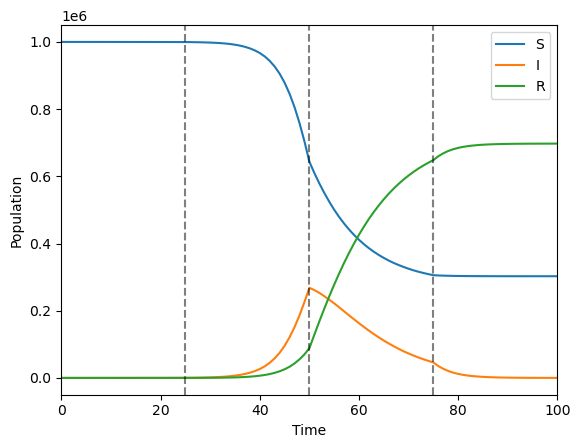

In [7]:
# plot the data
plot_population_data(S, R, I, gt_changing_points)

## MCMC algorithm

### Data preparation

In [8]:
# reshape and prepare the data
S = simulation["S"]
R = simulation["R"]
I = simulation["I"]

T = gt_total_time

In [9]:
#Save initial conditions
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
P_0 = I_0 / N_0

In [10]:
S = S[1:]
R = R[1:]
I = I[1:]

P = I / N_0

In [11]:
delta_R = R[1:] - R[:-1]
delta_R = np.concatenate([[R[0] - R_0], delta_R])

delta_I = S[:-1] - S[1:]
delta_I = np.concatenate([[S_0 - S[0]], delta_I])

print("Modified length: ", R.shape)
print("T: ", T)

Modified length:  (100,)
T:  100


### MCMC hyper-parameter

In [12]:
N = 15_000  # n samplings
burnin = 5000
thinning = 10
p = 0.01

### Algorithm parameters

In [13]:
betas = np.zeros([N, T])
gammas = np.zeros([N, T])
bs = np.zeros([N, T])
rs = np.zeros([N, T])
deltas = np.zeros([N, T])

In [14]:
# init following eq (3) hierarchical priors
delta_0 = np.random.binomial(1, p, size=T) 
delta_0[0] = 1
K_0 = np.sum(delta_0) # Number of Changeing points
eta_0 = np.cumsum(delta_0) #Number of Changing points up to time t

# vectors of K elements
r_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)
b_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)

r_0 = r_0[eta_0-1]
b_0 = b_0[eta_0-1]

beta_0 = np.random.exponential(1./b_0)
gamma_0 = np.random.beta(r_0, 1)

In [15]:
delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()

### MCMC

In [16]:
#MCMC  
K = np.sum(delta)
eta = np.cumsum(delta)
for n in range(N):

    #eq (5)
    delta_ = propose_delta(delta, T)
    #eqs (6-10
    delta = accept_delta(delta, delta_, beta, gamma, T, p)

    #eq (11)
    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    #eqs (12)
    beta = update_beta(b, T, S_0, P_0, S, P, delta_I)
    gamma = update_gamma(r, T, I_0, I, delta_R)

    #saving the samples
    betas[n, :] = beta
    gammas[n, :] = gamma
    deltas[n, :] = delta
    rs[n, :] = r
    bs[n, :] = b

## Analysis of data

In [17]:
beta_samples = betas[burnin::thinning, :]
delta_samples = deltas[burnin::thinning, :]
b_samples = bs[burnin::thinning, :]
r_samples = rs[burnin::thinning, :]
gamma_samples = gammas[burnin::thinning, :]
eta_samples = np.cumsum(delta_samples, axis=1)

n_samples = eta_samples.shape[0]

#eq (13)
q = np.zeros((T, T))
for n in range(n_samples):
    q += (eta_samples[n, :] == (eta_samples[n, :])[:, None]).astype(int)
q = q / n_samples

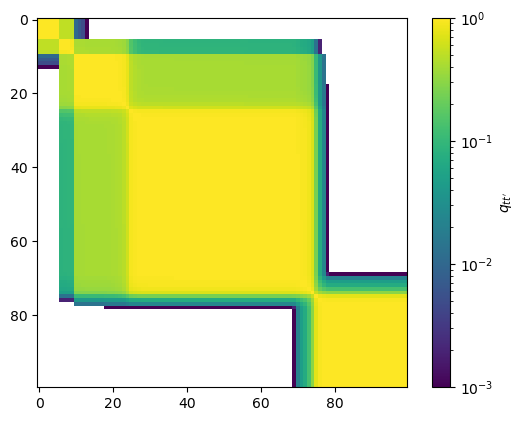

In [18]:
import matplotlib.colors as col
plt.imshow(q, norm = 'log')
plt.colorbar(label=r"$q_{tt'}$")


### Clustering

In [19]:
#eq (14)
delta_hat = np.array([0] * T)
delta_hat[0] = 1


eta_hat = np.cumsum(delta_hat)

continue_add = True
continue_swap = True

In [20]:
delta_final = clustering(delta_hat, eta_hat, q, T, continue_add, continue_swap)

### Changing points 

In [21]:
eta_final= np.cumsum(delta_final)
K_final= np.sum(delta_final)

tau_final= np.where(delta_final==1)[0]

In [22]:
tau_final

array([ 0, 10, 24, 75])

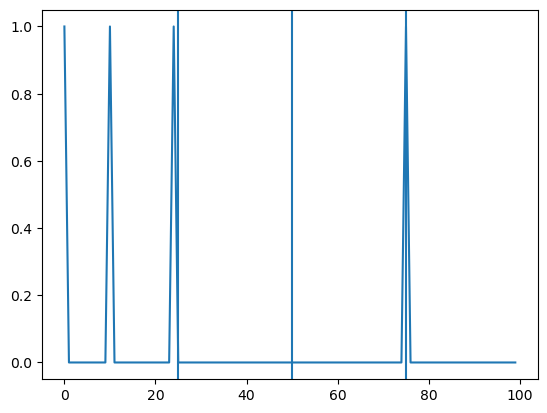

In [23]:
plt.plot(delta_final)
plt.axvline(25)
plt.axvline(75)
plt.axvline(50)

### Confidence intervals

In [24]:
alpha=0.05

In [25]:
def constraint_lhs(deltas, tau_l, tau_u):
    n_samples = deltas.shape[0]
    sum_tau = np.sum(deltas[:, tau_l:tau_u]) / n_samples
    return sum_tau

In [26]:
def possible_taus(tau_k, delta_tau):
    lower= tau_k
    upper= tau_k +delta_tau
    possible=[]
    for i in range(delta_tau+1):
        if upper<=T and lower>=0:
            possible.append((lower, upper))
            lower-=1
            upper-=1
    return possible

# possible_taus(4, 4)

In [27]:
ci_tau = []
for tau_k in tau_final:
    for delta_tau in range(2, T):
        candidate = []
        possible_taus_list = possible_taus(tau_k, delta_tau)
        for tau_l, tau_u in possible_taus_list:
            sum_tau = constraint_lhs(delta_samples, tau_l, tau_u)
            if sum_tau >= 1 - alpha:
                candidate.append([sum_tau, tau_l, tau_u])
        if len(candidate) > 0:
            break

    if len(candidate) == 0:
        ci_tau.append(np.array([0, T]))
    else:
        candidate = np.array(candidate)
        index_max_candidate = np.argmax(candidate[:, 0])
        ci_tau.append(candidate[index_max_candidate, 1:])

### Final Beta and Gamma

In [28]:
sum_beta = np.zeros(T)
sum_gamma = np.zeros(T)
n_smaples_reduced = delta_samples.shape[0]
for g in range(n_smaples_reduced):
    sum_beta += 1 / b_samples[g, :]
    sum_gamma+= r_samples[g, :]/(1+r_samples[g, :])
beta_final = sum_beta / n_smaples_reduced
gamma_final = sum_gamma / n_smaples_reduced

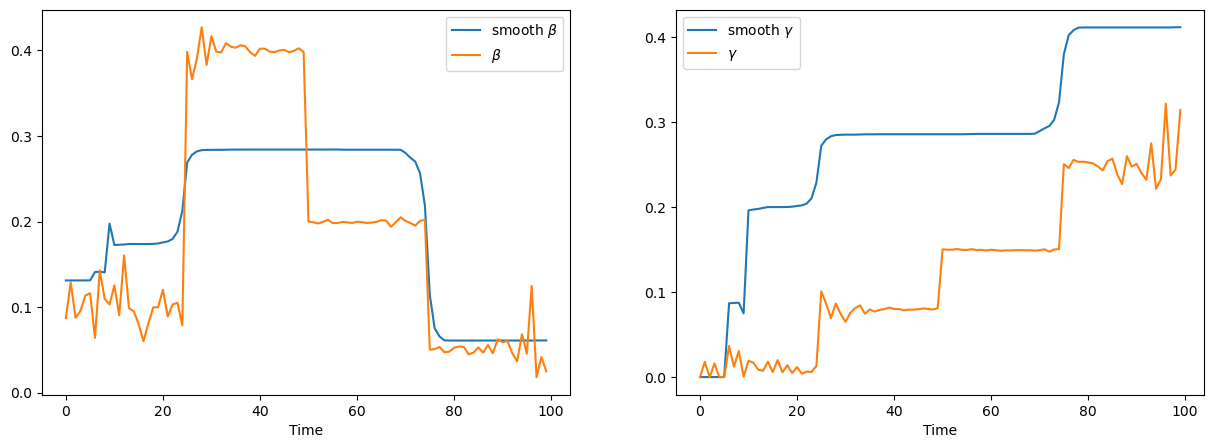

In [29]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.plot(beta_final, label=r'smooth $\beta$')
ax.plot(np.mean(beta_samples, axis=0), label=r'$\beta$')
ax.set_xlabel('Time')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(gamma_final, label=r'smooth $\gamma$')
ax.plot(np.mean(gamma_samples, axis=0), label=r'$\gamma$')
ax.set_xlabel('Time')
ax.legend()

## Bayesian analysis     

#### Plots

In [30]:
posterior_frequency = np.sum(delta_samples[:, 1:], axis = 0)/n_samples

Text(0.5, 0, 'Time[Days]')

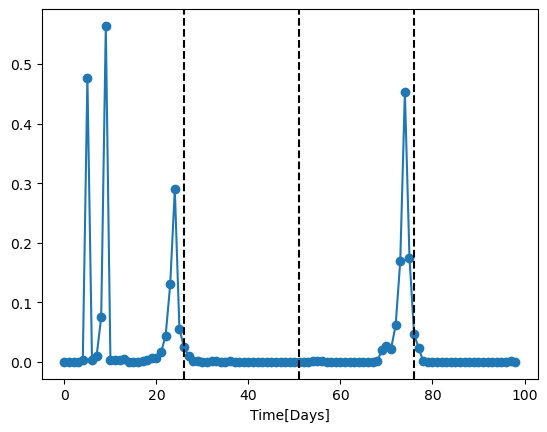

In [31]:
plt.plot(posterior_frequency, 'o-')
for gt in gt_changing_points[1:]:
    plt.axvline(gt, linestyle = '--', c = 'k')



plt.xlabel('Time[Days]')

#### Changing Points

In [32]:
K_final = np.sum(delta_final)

In [33]:
tau_final

array([ 0, 10, 24, 75])

In [34]:
ci_tau

[array([0., 2.]), array([ 6., 11.]), array([10., 26.]), array([71., 78.])]

### Metrics

#### ARI

In [35]:
TP = 0
FP = 0
FN = 0
TN = 0
for i in range(T):
    for j in range(i+1, T):
        TP = TP + int(eta_final[i]==eta_final[j] and gt_eta[i]==gt_eta[j])
        FP = FP + int(eta_final[i]!=eta_final[j] and gt_eta[i]==gt_eta[j])
        FN = FN + int(eta_final[i]==eta_final[j] and gt_eta[i]!=gt_eta[j])
        TN = TN + int(eta_final[i]!=eta_final[j] and gt_eta[i]!=gt_eta[j])

TP = TP*2/(T*(T-1))
FP = FP*2/(T*(T-1))
FN = FN*2/(T*(T-1))
TN = TN*2/(T*(T-1))

In [36]:
ARI = (TP + TN - ((TP+FP)*(TP+FN)+(TN+FP)*(TN+FN)))/(1-((TP+FP)*(TP+FN) + (TN+FP)*(TN+FN)))
print('ARI:', ARI)

ARI: 0.5969106235532198


#### Mutual information  (NON sono definiti k1 e k2)

In [37]:
MI = 0


for k1 in range(int(K_final)):
    for k2 in range(int(K_final)):
        n_k1 = np.sum(gt_eta == k1)
        n_k2 = np.sum(eta_final == k2)
        n_k1k2 = np.sum((gt_eta == k1) & (eta_final == k2))
        if n_k1k2 > 0:
            MI += n_k1k2/T * (np.log(T * n_k1k2) - np.log(n_k1 * n_k2))

In [38]:
print('MI:', MI)

MI: 0.6439276105846123
